# Welcome!

We've got some issues we want to resolve.

- [ ] First, we need to fix the data itself. Right now, there are invalid values for some data points (zero or negative) which get pruned off. Because of this, all of the ANOVAs are throwing errors about unbalanced data. We should remove `type = 1` for all `ezANOVA` calls once this is done.
- [ ] Second, we should gather all that data into a readable format that can be placed into the python graph for "Comparing Relative Performance of Docker"

# Getting Started

In this section, we import the necessary packages and load/transform our data.

In [259]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns

# For adding R code to the notebook
import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


First, we load in the Docker and native data into arrays of pandas dataframes.

In [260]:
docker_dfs = []
native_dfs = []

# EDIT THESE TWO ARRAYS TO ADD YOUR TEST DATA
folders = ['linux-lt215', 'linux-loaner002', 'GZ__Ubuntu__Xeon_E3-1290_V2_3.7GHz_x8__8GB_RAM', 'GZ__Mac__i9_2.3GHz_x8__16GB_RAM', 'osx-macmini180', 'windows-lt215', 'windows-loaner002']
devices = ['Ubuntu 1', 'Ubuntu 2', 'Ubuntu 3', 'Mac 1', 'Mac 2', 'Windows 1', 'Windows 2']
oss = ['Ubuntu', 'Ubuntu', 'Ubuntu', 'macOS', 'macOS', 'Windows', 'Windows']

for idx, f in enumerate(folders):
  docker_dfs += [[]] # Append empty list
  native_dfs += [[]]
  for i in range(10):
    docker_dfs[idx] += [pd.read_csv(f'../data/Final-Data/{f}/docker-{i}.csv')]
    native_dfs[idx] += [pd.read_csv(f'../data/Final-Data/{f}/native-{i}.csv')]

Next, we combine and reorganize the dataframes into the format below. This format makes it easy to manipulate.

| Device                | Condition | Batch | Run | Benchmark | Source Video | Image Path | Kernel Width (# pixels) | Time Elapsed (milliseconds) | CPU Usage (% of CPU) | Memory Usage (% of memory) |
|-----------------------|-----------|-------|-----|-----------|--------------|------------|-------------------------|-----------------------------|----------------------|----------------------------|
| Macbook Pro 16 (2019) | Docker    | 1     | 1   | resize    | Video 1      | ./path     | 3                       | 55.213                      | 25.0                 | 9.1                        |

In [261]:
# We're going to arrange everything in a massive 2D list
all_dfs_list = []
s = set()

# img_sizes = {
#     'Video1': '1921x1080 px',
#     'Video2': '1280x720 px',
#     'Video3': '853x480 px',
#     'Video4': '1280x720 px',
# }
bench_translator = {
    'resize': 'Resize',
    'rotate': 'Rotate',
    'mirror': 'Mirror',
    'contour': 'Contour',
    'contrastRandomization': 'Contrast Randomization',
    'gaussianBlur': 'Gaussian Blur',
    'meanThresh': 'Mean Thresholding',
    'gradientSobel': 'Gradient Sobel',
    'brightnessRandomization': 'Brightness Randomization',
    'computeCanny': 'Compute Canny',
    'goodFeatures': 'Good Features',
    'detectSift': 'SIFT',
    'detectSurf': 'SURF',
    'houghLine': 'Hough Lines',
    'measureMemoryUsage': 'Load Image',
    'computeHistogram': 'Compute Histogram',
}

for idx, d in enumerate(devices):    
  # First, get the docker dfs
  for df_index in range(10):
    for _, row in docker_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Docker',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

  # Second, get the native dfs
  for df_index in range(10):
    for _, row in native_dfs[idx][df_index].iterrows():
      for i in range(1, 11):
        # TODO: fix this!! We should never have negative or zero results.
        if row[f'Time Elapsed {i} (milliseconds)'] <= 0:
          s.add(row['Benchmark'])
          continue
        all_dfs_list += [[
          d,                 # Device
          oss[idx],          # Operating System
          'Native',          # Condition
          df_index + 1,      # Batch
          i,                 # Run
          df_index * 10 + i, # Trial
          row['Benchmark'],
          row['Source Video'],
          row['Image Path'],
          row['Kernel Width (# pixels)'],
          row[f'Time Elapsed {i} (milliseconds)'],
          math.log10(row[f'Time Elapsed {i} (milliseconds)']),
          row[f'CPU usage {i} (% of CPU)'],
          row[f'memory usage {i} (% of memory)']
        ]]

print('The following benchmarks have missing values because of negative numbers:', s)

# Finally, make the dataframe to put the data
all_df = pd.DataFrame(data=all_dfs_list, columns=[
  'Device',
  'Operating System',
  'Condition',
  'Batch',
  'Run',
  'Trial', # the overall trial (unique ID)
  'Benchmark',
  'Source Video',
  'Image Path',
  'Kernel Width (# pixels)',
  'Run Time (ms)',
  'LogTime',
  'CPU Usage (% of CPU)',
  'Memory Usage (% of memory)'
])

all_df['Benchmark'] = all_df['Benchmark'].apply(lambda a : bench_translator[a])

The following benchmarks have missing values because of negative numbers: {'contour', 'rotate', 'computeHistogram', 'gaussianBlur'}


In [262]:
all_df.head()

,Device,Operating System,Condition,Batch,Run,Trial,Benchmark,Source Video,Image Path,Kernel Width (# pixels),Run Time (ms),LogTime,CPU Usage (% of CPU),Memory Usage (% of memory)
0,Ubuntu 1,Ubuntu,Docker,1,1,1,Load Image,Video1,./data/Video1/Confetti01.png and 9 others,3,50.139666,1.700181,71.4,24.2
1,Ubuntu 1,Ubuntu,Docker,1,2,2,Load Image,Video1,./data/Video1/Confetti01.png and 9 others,3,55.848122,1.747009,56.0,25.7
2,Ubuntu 1,Ubuntu,Docker,1,3,3,Load Image,Video1,./data/Video1/Confetti01.png and 9 others,3,42.872667,1.632181,58.8,26.5
3,Ubuntu 1,Ubuntu,Docker,1,4,4,Load Image,Video1,./data/Video1/Confetti01.png and 9 others,3,42.201519,1.625328,46.7,27.0
4,Ubuntu 1,Ubuntu,Docker,1,5,5,Load Image,Video1,./data/Video1/Confetti01.png and 9 others,3,41.270494,1.615640,47.1,27.1


# Time

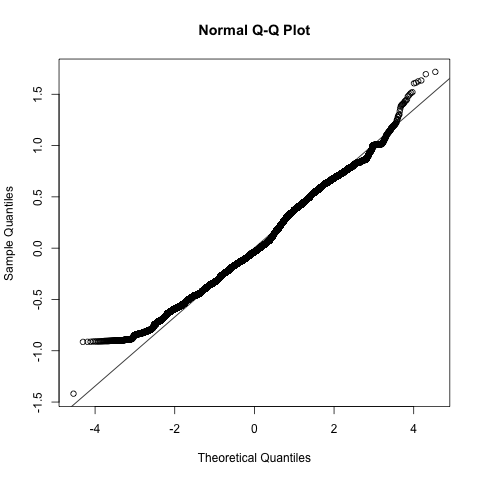

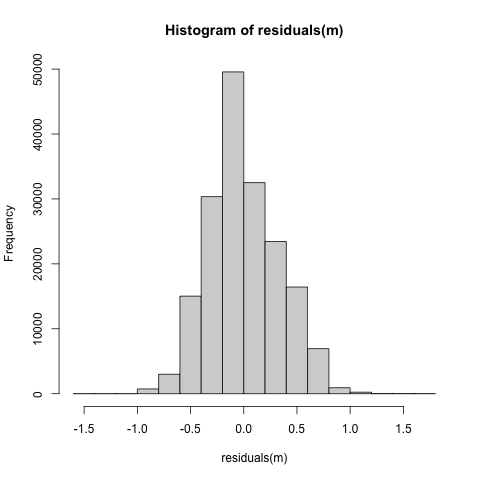

In [80]:
%%R -i all_df

# Sanitize dataframe column names
library(janitor)
all_df <- clean_names(all_df)

all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)

# Use a QQ plot and histogram to check normality
# We use log_time because we already checked that runtime_ms is not normal
m = aov(log_time ~ condition*benchmark, data=all_df)
qqnorm(residuals(m))
qqline(residuals(m))
hist(residuals(m))

# Anovas

In this section, we perform a series of stats in order to determine whether the differences are significant for various comparisons.

We have the following set of questions we want to ask:
1. Two-way ANOVA with three independent variables: Docker vs Native, Benchmark, and OS. This probably won't show anything useful and it will probably hide a lot of valuable information, but it's a start.
2. For each benchmark, do a two-way ANOVA with two variables: Docker vs Native and OS. This shows any interaction effect.
3. For each benchmark and OS (that's `NUM_OSs * NUM_BENCHMARKS`—it's a lot of tests!), do a one-way ANOVA considering just Docker vs Native. This shows if there is a signficant difference for each column of the massive relative performance graph showing all benches/OSs.

In [81]:
%%R -i all_df

library(tidyverse) # Used for filtering out data irrelevant to a given test
library(janitor) # Fix dataframe column names to sanitize
# Libraries for the ezANOVA
library(ez)
library(apa)
library(lsr)
all_df <- clean_names(all_df)

all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$source_video <- factor(all_df$source_video)
all_df$kernel_width_number_pixels <- factor(all_df$kernel_width_number_pixels)

# print(head(all_df))

# type=1 only if we removed stuff
anoResults <- ezANOVA(data=all_df, type=1, dv=log_time, wid=device, within=c(condition, benchmark), between=operating_system)
print(anoResults)

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                                Effect DFn DFd            F            p p<.05
1                     operating_system   2   4 1.549894e+00 3.174163e-01      
2                            condition   1   4 2.239320e-03 9.645255e-01      
4                            benchmark  15  60 1.258966e+03 4.663976e-69     *
3           operating_system:condition   2   4 6.871293e+00 5.082603e-02      
5           operating_system:benchmark  30  60 2.496638e+00 1.290247e-03     *
6                  condition:benchmark  15  60 1.949667e+01 1.205400e-17     *
7 operating_system:condition:benchmark  30  60 7.156230e+00 6.297927e-11     *
           ges
1 3.446060e-01
2 1.196916e-05
4 9.865882e-01
3 6.842857e-02
5 2.258604e-01
6 2.445164e-01
7 1.919810e-01



## Significance of Docker on Each Benchmark

The following does a TON of anovas (one for each comparison we want to make). The reason this is done as a crapload of separate anovas instead of a single beast is because we can only do a Tukey on a single variable, making it kinda useless for our use case. We want to know if, for each benchmark & os, docker changes performance. So, that's a lot of combinations and each one needs a test somehow!

If somebody knows how to do this better, you are welcome to refactor this. Otherwise, this should calculate everything we need. It does not do all the checks it ought to regarding normality, etc, which may be a weakness.

In [264]:
%%R -i all_df -o significance

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

significance <- data.frame(benchmark = character(),
             os = character(),
             p = double())

print(levels(all_df$benchmark))

print("**************************** For each benchmark, look for differences ****************************")
for (b in levels(all_df$benchmark)) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    
    result <- ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system, return_aov=TRUE, detailed=TRUE)
    print(result)
#     print("TRYING THIS:")
#     print(summary(glht(result$aov, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    print("The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey")
    m = aov(log_time ~ condition * operating_system, data=bench_df)
    print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual t-tests for each benchmark and OS
    print(paste("--------------------------Test condition diffs by OS---------------------------"))
    print("The following compares conditions for a single OS")
    for (os in levels(bench_df$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        
        d_os_bench_df <- filter(os_bench_df, condition == "Docker")
        print(paste("Docker: Mean: ", mean(d_os_bench_df$run_time_ms), ", StDev: ", sd(d_os_bench_df$run_time_ms)))
        n_os_bench_df <- filter(os_bench_df, condition == "Native")
        print(paste("Native: Mean: ", mean(n_os_bench_df$run_time_ms), ", StDev: ", sd(n_os_bench_df$run_time_ms)))
        print(paste("Difference: Absolute: ", mean(d_os_bench_df$run_time_ms) - mean(n_os_bench_df$run_time_ms),
                    ", Percent: ", (mean(d_os_bench_df$run_time_ms)/mean(n_os_bench_df$run_time_ms) - 1) * 100, "%"))
        
        t_result <- t.test(log_time ~ condition, var.equal=FALSE, paired=FALSE, data=os_bench_df)
        print(t_result)
#         m = aov(log_time ~ condition, data=os_bench_df)
#         m_summary = summary(m)
#         print(m_summary)
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
        # generalized eta squared
        
#         print(t_result$statistic)
#         print(t_result$p.value)
        
        significance[nrow(significance) + 1,] = list(b, os, t_result$p.value)
    }
    
    print(paste("--------------------------Test OS diffs by condition---------------------------"))
    print("This shows differences in OS for a specific benchmark and condition")
    for (c in levels(all_df$condition)) {
        cond_df <- filter(bench_df, condition == c)
        print(paste("--------------------------Condition: ", c, "---------------------------"))
        print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system, return_aov=TRUE, detailed=TRUE))
        m = aov(log_time ~ operating_system, data=cond_df)
        print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    }
}

print("**************************** For each condition (overall, over all benchmarks), look for differences between OSs ****************************")
print("Note that none of the differences are significant")
for (c in levels(all_df$condition)) {
    cond_df <- filter(all_df, condition == c)
    
    print("------------------------------------------------------------")
    print(c)
    print("------------------------------------------------------------")
    print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system))
#     m <- aov(log_time ~ operating_system, data=cond_df)
#     print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
}

# print(head(significance))


 [1] "Brightness Randomization" "Compute Canny"           
 [3] "Compute Histogram"        "Contour"                 
 [5] "Contrast Randomization"   "Gaussian Blur"           
 [7] "Good Features"            "Gradient Sobel"          
 [9] "Hough Lines"              "Load Image"              
[11] "Mean Thresholding"        "Mirror"                  
[13] "Resize"                   "Rotate"                  
[15] "SIFT"                     "SURF"                    
[1] "**************************** For each benchmark, look for differences ****************************"
[1] "------------------------------------------------------------"
[1] "Brightness Randomization"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.06885428 0.063830082  2.157424
2                  condition   1   4 0.04850020 0.003754492 51.671654
3 operating_system:condition   2   4 0.04837584 0.003754492 25.769581
            p p<.05       ges
1 0.231425576       0.5046530
2 0.001984234     * 0.4177998
3 0.005187061     * 0.4171755

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 1.415677

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.06885428 0.06383008
Deg. of Freedom                2          4

Residual standard error: 0.1263231
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.04850020                 0.04837584 0.00375449
Deg. of Freedom          1                          2          4

Residual sta

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd          SSn       SSd          F         p p<.05
1 operating_system   2   4 0.0009241907 0.0186428 0.09914721 0.9077666      
         ges
1 0.04723214

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system   Residuals
Sum of Squares       0.000924191 0.018642799
Deg. of Freedom                2           4

Residual standard error: 0.06826932
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)  
Ubuntu - macOS == 0   -0.001236   0.008976  -0.138   0.8905  
Windows - macOS == 0   0.024668   0.009832   2.509   0.0243 *
Windows - Ubuntu == 0  0.025904   0.008976   2.886   0.0117 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn        SSd        F          p p<.05
1 operating_system   2   4 0.1163059 0.04894177 4.752828 0.08771797      
        ges
1 0.7038278

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.11630592 0.04894177
Deg. of Freedom                2          4

Residual standard error: 0.1106139
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.062502   0.009378  -6.665 2.91e-11 ***
Windows - macOS == 0   0.242021   0.010273  23.559  < 2e-16 ***
Windows - Ubuntu == 0  0.304523   0.009378  32.472  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn         SSd        F
1           operating_system   2   4 0.098454531 0.136557447 1.441950
2                  condition   1   4 0.000910203 0.002860807 1.272652
3 operating_system:condition   2   4 0.007263030 0.002860807 5.077609
           p p<.05         ges
1 0.33763758       0.413895733
2 0.32235228       0.006486232
3 0.07985219       0.049515724

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 0.9416939

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.09845453 0.13655745
Deg. of Freedom                2          4

Residual standard error: 0.1847684
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.000910203                0.007263030 0.002860807
Deg. of Freedom           1                          2           4

R

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.02862157 0.05267932 1.086634 0.4198457      
       ges
1 0.352045

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02862157 0.05267932
Deg. of Freedom                2          4

Residual standard error: 0.1147599
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.04274    0.01216   3.516 0.000442 ***
Windows - macOS == 0   0.16166    0.01332  12.138  < 2e-16 ***
Windows - Ubuntu == 0  0.11892    0.01216   9.781  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm metho

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.07709599 0.08673893 1.777656 0.2802949      
        ges
1 0.4705712

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.07709599 0.08673893
Deg. of Freedom                2          4

Residual standard error: 0.1472574
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.12667    0.01277   9.921   <2e-16 ***
Windows - macOS == 0   0.27722    0.01399  19.820   <2e-16 ***
Windows - Ubuntu == 0  0.15055    0.01277  11.791   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm met

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn        SSd         F
1           operating_system   2   4 0.294067315 0.29778245 1.9750480
2                  condition   1   4 0.001406923 0.01665098 0.3379794
3 operating_system:condition   2   4 0.056008246 0.01665098 6.7273200
           p p<.05         ges
1 0.25314843       0.483265331
2 0.59218355       0.004454537
3 0.05251679       0.151193156

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.3767535

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.2940673 0.2977824
Deg. of Freedom                2         4

Residual standard error: 0.2728472
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.00140692                 0.05600825 0.01665098
Deg. of Freedom          1                          2          4

Residual 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn      SSd        F         p p<.05
1 operating_system   2   4 0.2177435 0.102027 4.268353 0.1018013      
        ges
1 0.6809369

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.2177435 0.1020270
Deg. of Freedom                2         4

Residual standard error: 0.1597083
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.213477   0.007942   26.88   <2e-16 ***
Windows - macOS == 0  0.466034   0.008700   53.57   <2e-16 ***
Windows - Ubuntu == 0 0.252557   0.007939   31.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1]

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      SSn       SSd        F         p p<.05
1 operating_system   2   4 0.132332 0.2124065 1.246026 0.3796259      
        ges
1 0.3838621

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.1323320 0.2124065
Deg. of Freedom                2         4

Residual standard error: 0.2304379
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.321552   0.008998  35.735  < 2e-16 ***
Windows - macOS == 0   0.268957   0.009857  27.286  < 2e-16 ***
Windows - Ubuntu == 0 -0.052595   0.008998  -5.845 5.35e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn        SSd         F         p
1           operating_system   2   4 0.055881842 0.07242028  1.543265 0.3186051
2                  condition   1   4 0.001688975 0.00508812  1.327779 0.3133808
3 operating_system:condition   2   4 0.030535578 0.00508812 12.002697 0.0204003
  p<.05        ges
1       0.41893502
2       0.02132615
3     * 0.28262175

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 0.233528

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.05588184 0.07242028
Deg. of Freedom                2          4

Residual standard error: 0.1345551
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.001688975                0.030535578 0.005088120
Deg. of Freedom           1                          2           4

Residual s

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F         p p<.05
1 operating_system   2   4 0.00197284 0.01992423 0.1980343 0.8279251      
         ges
1 0.09009609

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00197284 0.01992423
Deg. of Freedom                2          4

Residual standard error: 0.07057661
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.008071   0.008109   0.995     0.32    
Windows - macOS == 0  0.041233   0.008884   4.641 1.06e-05 ***
Windows - Ubuntu == 0 0.033162   0.008110   4.089 8.79e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- hol

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd       F         p p<.05
1 operating_system   2   4 0.08444458 0.05758417 2.93291 0.1643818      
        ges
1 0.5945598

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.08444458 0.05758417
Deg. of Freedom                2          4

Residual standard error: 0.1199835
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.101130   0.008636   11.71   <2e-16 ***
Windows - macOS == 0  0.285445   0.009461   30.17   <2e-16 ***
Windows - Ubuntu == 0 0.184315   0.008636   21.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm metho

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd          F
1           operating_system   2   4 0.13532615 0.151989329   1.780732
2                  condition   1   4 0.06674195 0.002087311 127.900350
3 operating_system:condition   2   4 0.18587443 0.002087311 178.099420
             p p<.05       ges
1 0.2798389426       0.4676049
2 0.0003484200     * 0.3022479
3 0.0001233205     * 0.5467682

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.09479958

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.1353262 0.1519893
Deg. of Freedom                2         4

Residual standard error: 0.194929
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.06674195                 0.18587443 0.00208731
Deg. of Freedom          1                          2          4

Resid

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd          F         p p<.05
1 operating_system   2   4 0.002749232 0.06323284 0.08695584 0.9184034      
         ges
1 0.04166635

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00274923 0.06323284
Deg. of Freedom                2          4

Residual standard error: 0.1257307
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.026996   0.008809  -3.065  0.00438 ** 
Windows - macOS == 0  -0.052423   0.009650  -5.432 1.74e-07 ***
Windows - Ubuntu == 0 -0.025427   0.008809  -2.886  0.00438 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn       SSd        F          p p<.05
1 operating_system   2   4 0.3184513 0.0908438 7.010965 0.04926261     *
        ges
1 0.7780482

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.3184513 0.0908438
Deg. of Freedom                2         4

Residual standard error: 0.1507015
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.026984   0.008767   3.078   0.0021 ** 
Windows - macOS == 0  0.487682   0.009604  50.778   <2e-16 ***
Windows - Ubuntu == 0 0.460698   0.008767  52.547   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd          SSn        SSd         F
1           operating_system   2   4 1.882820e-01 0.24684947 1.5254802
2                  condition   1   4 3.358571e-04 0.00037188 3.6125321
3 operating_system:condition   2   4 4.583227e-05 0.00037188 0.2464896
          p p<.05          ges
1 0.3218277       0.4323319093
2 0.1301388       0.0013566848
3 0.7925947       0.0001853553

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.3766799

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.1882820 0.2468495
Deg. of Freedom                2         4

Residual standard error: 0.2484197
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                   condition operating_system:condition    Residuals
Sum of Squares  0.0003358571               0.0000458323 0.0003718800
Deg. of Freedom            1                          2        

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn       SSd        F         p p<.05
1 operating_system   2   4 0.09573908 0.1186938 1.613211 0.3063891      
        ges
1 0.4464757

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.09573908 0.11869380
Deg. of Freedom                2          4

Residual standard error: 0.1722598
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.22836    0.01304  17.516  < 2e-16 ***
Windows - macOS == 0   0.28920    0.01428  20.251  < 2e-16 ***
Windows - Ubuntu == 0  0.06084    0.01303   4.667 3.12e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm metho

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn       SSd        F        p p<.05
1 operating_system   2   4 0.09258874 0.1285275 1.440761 0.337871      
        ges
1 0.4187333

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.09258874 0.12852754
Deg. of Freedom                2          4

Residual standard error: 0.1792537
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.22030    0.01294  17.025  < 2e-16 ***
Windows - macOS == 0   0.28725    0.01417  20.265  < 2e-16 ***
Windows - Ubuntu == 0  0.06695    0.01294   5.174 2.37e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.04310623 0.066588586  1.294703
2                  condition   1   4 0.01252981 0.002905096 17.252175
3 operating_system:condition   2   4 0.05209612 0.002905096 35.865329
            p p<.05       ges
1 0.368491439       0.3828265
2 0.014219019     * 0.1527588
3 0.002789822     * 0.4284580

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 1.342974

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.04310623 0.06658859
Deg. of Freedom                2          4

Residual standard error: 0.1290238
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.01252981                 0.05209612 0.00290510
Deg. of Freedom          1                          2          4

Residual sta

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd          SSn        SSd          F         p p<.05
1 operating_system   2   4 0.0003098783 0.02168539 0.02857945 0.9720217      
        ges
1 0.0140884

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system   Residuals
Sum of Squares       0.000309878 0.021685393
Deg. of Freedom                2           4

Residual standard error: 0.07362981
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)
Ubuntu - macOS == 0    0.004264   0.009424   0.452    0.651
Windows - macOS == 0  -0.011642   0.010323  -1.128    0.519
Windows - Ubuntu == 0 -0.015906   0.009424  -1.688    0.275
(Adjusted p values reported -- holm method)

[1] "--------------------------Condition:  Native -----------

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.09489247 0.04780829 3.969708 0.1122416      
        ges
1 0.6649752

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.09489247 0.04780829
Deg. of Freedom                2          4

Residual standard error: 0.1093255
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.089804   0.009528   9.425   <2e-16 ***
Windows - macOS == 0  0.298116   0.010437  28.563   <2e-16 ***
Windows - Ubuntu == 0 0.208313   0.009528  21.863   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm met

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.08955680 0.054074989  3.312319
2                  condition   1   4 0.01060794 0.007885588  5.380928
3 operating_system:condition   2   4 0.10720552 0.007885588 27.190241
            p p<.05       ges
1 0.141739783       0.5910662
2 0.081164939       0.1461783
3 0.004694449     * 0.6337293

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 0.2000471

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.08955680 0.05407499
Deg. of Freedom                2          4

Residual standard error: 0.1162701
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.01060794                 0.10720552 0.00788559
Deg. of Freedom          1                          2          4

Residual st

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F        p p<.05
1 operating_system   2   4 0.02248871 0.01182111 3.804838 0.118708      
        ges
1 0.6554598

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02248871 0.01182111
Deg. of Freedom                2          4

Residual standard error: 0.05436247
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.136335   0.008093 -16.846  < 2e-16 ***
Windows - macOS == 0  -0.070456   0.008866  -7.947 2.22e-15 ***
Windows - Ubuntu == 0  0.065879   0.008093   8.140 8.88e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn        SSd        F          p p<.05
1 operating_system   2   4 0.1742736 0.05013946 6.951554 0.04991868     *
        ges
1 0.7765751

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.17427360 0.05013946
Deg. of Freedom                2          4

Residual standard error: 0.1119592
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.087612   0.009782   8.956   <2e-16 ***
Windows - macOS == 0  0.392485   0.010716  36.626   <2e-16 ***
Windows - Ubuntu == 0 0.304872   0.009782  31.165   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm met

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn        SSd          F
1           operating_system   2   4 0.19147432 0.14979383   2.556505
2                  condition   1   4 0.46706996 0.01235016 151.275788
3 operating_system:condition   2   4 0.04140639 0.01235016   6.705402
             p p<.05       ges
1 0.1926621256       0.5414717
2 0.0002510219     * 0.7423071
3 0.0527815717       0.2034208

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 1.484969

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.1914743 0.1497938
Deg. of Freedom                2         4

Residual standard error: 0.193516
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                condition operating_system:condition Residuals
Sum of Squares  0.4670700                  0.0414064 0.0123502
Deg. of Freedom         1                          2         4

Residual standard 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn       SSd        F         p p<.05
1 operating_system   2   4 0.2054006 0.1057034 3.886358 0.1154427      
        ges
1 0.6602313

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.2054006 0.1057034
Deg. of Freedom                2         4

Residual standard error: 0.1625603
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.34736    0.01126  30.862  < 2e-16 ***
Windows - macOS == 0   0.41439    0.01233  33.610  < 2e-16 ***
Windows - Ubuntu == 0  0.06703    0.01126   5.956 2.75e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F        p p<.05
1 operating_system   2   4 0.02748013 0.05644062 0.9737714 0.452319      
        ges
1 0.3274534

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02748013 0.05644062
Deg. of Freedom                2          4

Residual standard error: 0.1187862
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.122750   0.009434  13.011  < 2e-16 ***
Windows - macOS == 0  0.154763   0.010335  14.975  < 2e-16 ***
Windows - Ubuntu == 0 0.032014   0.009434   3.393 0.000695 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm met

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd          F
1           operating_system   2   4 0.03212405 0.081737478  0.7860299
2                  condition   1   4 0.02264063 0.001426947 63.4659440
3 operating_system:condition   2   4 0.03789913 0.001426947 53.1191970
            p p<.05       ges
1 0.515333597       0.2786406
2 0.001345159     * 0.2139844
3 0.001316601     * 0.3130515

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 1.265976

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.03212405 0.08173748
Deg. of Freedom                2          4

Residual standard error: 0.1429488
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.02264063                 0.03789913 0.00142695
Deg. of Freedom          1                          2          4

Residual

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.05379822 0.03183055 3.380288 0.1381812      
        ges
1 0.6282727

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.05379822 0.03183055
Deg. of Freedom                2          4

Residual standard error: 0.08920559
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.129727   0.007784 -16.665   <2e-16 ***
Windows - macOS == 0   0.075533   0.008527   8.858   <2e-16 ***
Windows - Ubuntu == 0  0.205261   0.007784  26.369   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- hol

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F         p p<.05
1 operating_system   2   4 0.01622496 0.05133387 0.6321347 0.5773561      
        ges
1 0.2401605

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.01622496 0.05133387
Deg. of Freedom                2          4

Residual standard error: 0.1132849
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.098421   0.008515  11.558   <2e-16 ***
Windows - macOS == 0  0.115803   0.009328  12.414   <2e-16 ***
Windows - Ubuntu == 0 0.017382   0.008515   2.041   0.0413 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm m

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn         SSd        F
1           operating_system   2   4 0.025466187 0.031783528 1.602477
2                  condition   1   4 0.007873007 0.003634732 8.664195
3 operating_system:condition   2   4 0.006940648 0.003634732 3.819070
           p p<.05       ges
1 0.30821768       0.4182708
2 0.04224164     * 0.1818613
3 0.11812800       0.1638533

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 0.1963957

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.02546619 0.03178353
Deg. of Freedom                2          4

Residual standard error: 0.08913968
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.007873007                0.006940648 0.003634732
Deg. of Freedom           1                          2           4

Residual

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn       SSd         F        p p<.05
1 operating_system   2   4 0.003824087 0.0126671 0.6037826 0.589998      
        ges
1 0.2318867

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system   Residuals
Sum of Squares       0.003824087 0.012667098
Deg. of Freedom                2           4

Residual standard error: 0.0562741
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.005472   0.009425  -0.581    0.562    
Windows - macOS == 0   0.048211   0.010325   4.670 6.18e-06 ***
Windows - Ubuntu == 0  0.053684   0.009425   5.696 3.87e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- h

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.02858275 0.02275116 2.512641 0.1964258      
        ges
1 0.5568005

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02858275 0.02275116
Deg. of Freedom                2          4

Residual standard error: 0.07541744
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.057975   0.009371   6.186 6.59e-10 ***
Windows - macOS == 0  0.165875   0.010266  16.158  < 2e-16 ***
Windows - Ubuntu == 0 0.107900   0.009371  11.514  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm me

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd       SSn       SSd        F          p
1           operating_system   2   4 0.2013371 0.2942791 1.368341 0.35255572
2                  condition   1   4 0.1743026 0.1460502 4.773772 0.09422757
3 operating_system:condition   2   4 0.1481155 0.1460502 2.028282 0.24650184
  p<.05       ges
1       0.3137723
2       0.2835886
3       0.2517068

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.4657938

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.2013371 0.2942791
Deg. of Freedom                2         4

Residual standard error: 0.2712375
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                condition operating_system:condition Residuals
Sum of Squares  0.1743026                  0.1481155 0.1460502
Deg. of Freedom         1                          2         4

Residual standard error: 0.1910826
Esti

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd         F         p p<.05
1 operating_system   2   4 0.003469621 0.03822203 0.1815508 0.8404838      
         ges
1 0.08322099

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00346962 0.03822203
Deg. of Freedom                2          4

Residual standard error: 0.09775228
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.042195   0.008824   4.782 3.57e-06 ***
Windows - macOS == 0  0.055865   0.009666   5.779 2.37e-08 ***
Windows - Ubuntu == 0 0.013670   0.008824   1.549    0.121    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- h

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      SSn       SSd       F         p p<.05       ges
1 operating_system   2   4 0.345983 0.4021072 1.72085 0.2889188       0.4624884

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.3459830 0.4021072
Deg. of Freedom                2         4

Residual standard error: 0.3170596
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.53677    0.01408   38.12   <2e-16 ***
Windows - macOS == 0   0.30905    0.01542   20.04   <2e-16 ***
Windows - Ubuntu == 0 -0.22771    0.01408  -16.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "----

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.11469309 0.157175914  1.459423
2                  condition   1   4 0.01566186 0.003313405 18.907269
3 operating_system:condition   2   4 0.04349900 0.003313405 26.256375
            p p<.05        ges
1 0.334235523       0.41678932
2 0.012173803     * 0.08891147
3 0.005009877     * 0.21324260

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.09990285

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.1146931 0.1571759
Deg. of Freedom                2         4

Residual standard error: 0.1982271
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.01566186                 0.04349900 0.00331340
Deg. of Freedom          1                          2          4

Residual

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd        F         p p<.05
1 operating_system   2   4 0.008692195 0.06341844 0.274122 0.7734504      
        ges
1 0.1205397

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00869220 0.06341844
Deg. of Freedom                2          4

Residual standard error: 0.1259151
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.065407   0.007166   9.128  < 2e-16 ***
Windows - macOS == 0  0.089154   0.007850  11.358  < 2e-16 ***
Windows - Ubuntu == 0 0.023747   0.007166   3.314 0.000926 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm m

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn        SSd        F         p p<.05
1 operating_system   2   4 0.1494999 0.09707088 3.080221 0.1549868      
        ges
1 0.6063164

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.14949989 0.09707088
Deg. of Freedom                2          4

Residual standard error: 0.155781
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.303483   0.007477  40.587  < 2e-16 ***
Windows - macOS == 0  0.347269   0.008191  42.396  < 2e-16 ***
Windows - Ubuntu == 0 0.043786   0.007477   5.856 5.02e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn        SSd         F
1           operating_system   2   4 0.033422291 0.11495926 0.5814632
2                  condition   1   4 0.003902154 0.01771894 0.8809003
3 operating_system:condition   2   4 0.049236892 0.01771894 5.5575450
           p p<.05        ges
1 0.60024438       0.20121730
2 0.40109390       0.02857039
3 0.07003232       0.27065865

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.1711353

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.03342229 0.11495926
Deg. of Freedom                2          4

Residual standard error: 0.1695282
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.00390215                 0.04923689 0.01771894
Deg. of Freedom          1                          2          4

Residual s

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd          F         p p<.05
1 operating_system   2   4 0.001524402 0.03168071 0.09623532 0.9102903      
         ges
1 0.04590865

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00152440 0.03168071
Deg. of Freedom                2          4

Residual standard error: 0.08899538
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)   
Ubuntu - macOS == 0   -0.028627   0.009426  -3.037  0.00480 **
Windows - macOS == 0   0.002239   0.010326   0.217  0.82833   
Windows - Ubuntu == 0  0.030866   0.009424   3.275  0.00319 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported --

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn       SSd        F         p p<.05
1 operating_system   2   4 0.08113478 0.1009975 1.606669 0.3075016      
        ges
1 0.4454718

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.08113478 0.10099748
Deg. of Freedom                2          4

Residual standard error: 0.1589005
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.25732    0.01022  25.189  < 2e-16 ***
Windows - macOS == 0   0.18865    0.01119  16.857  < 2e-16 ***
Windows - Ubuntu == 0 -0.06868    0.01022  -6.722 1.96e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm metho

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn         SSd         F
1           operating_system   2   4 0.037990146 0.092510118 0.8213187
2                  condition   1   4 0.004252251 0.003877649 4.3864220
3 operating_system:condition   2   4 0.002265059 0.003877649 1.1682641
          p p<.05        ges
1 0.5025227       0.28271124
2 0.1043133       0.04225209
3 0.3984898       0.02295990

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 2.327054

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.03799015 0.09251012
Deg. of Freedom                2          4

Residual standard error: 0.1520774
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.004252251                0.002265059 0.003877649
Deg. of Freedom           1                          2           4

Residu

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F        p p<.05
1 operating_system   2   4 0.01805292 0.03322951 1.086559 0.419866      
        ges
1 0.3520293

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.01805292 0.03322951
Deg. of Freedom                2          4

Residual standard error: 0.09114482
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.03135    0.01106   2.835  0.00459 ** 
Windows - macOS == 0   0.12749    0.01211  10.527  < 2e-16 ***
Windows - Ubuntu == 0  0.09614    0.01106   8.696  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm meth

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F         p p<.05
1 operating_system   2   4 0.02220229 0.06315825 0.7030684 0.5474518      
        ges
1 0.2601001

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02220229 0.06315825
Deg. of Freedom                2          4

Residual standard error: 0.1256565
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.09040    0.01004   9.008  < 2e-16 ***
Windows - macOS == 0   0.14739    0.01099  13.407  < 2e-16 ***
Windows - Ubuntu == 0  0.05698    0.01004   5.678 1.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm m

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.54629311 0.393668676  2.775395
2                  condition   1   4 0.01525790 0.001552502 39.311782
3 operating_system:condition   2   4 0.00363552 0.001552502  4.683434
            p p<.05         ges
1 0.175404741       0.580228166
2 0.003302362     * 0.037170964
3 0.089548993       0.009114852

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 2.408799

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.5462931 0.3936687
Deg. of Freedom                2         4

Residual standard error: 0.3137151
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.015257903                0.003635520 0.001552502
Deg. of Freedom           1                          2           4

R

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn       SSd        F         p p<.05
1 operating_system   2   4 0.2427077 0.2031062 2.389958 0.2075579      
        ges
1 0.5444148

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.2427077 0.2031062
Deg. of Freedom                2         4

Residual standard error: 0.2253365
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.31753    0.01175   27.03   <2e-16 ***
Windows - macOS == 0   0.48241    0.01287   37.49   <2e-16 ***
Windows - Ubuntu == 0  0.16488    0.01175   14.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn      SSd        F         p p<.05
1 operating_system   2   4 0.3072209 0.192115 3.198303 0.1480256      
        ges
1 0.6152591

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.3072209 0.1921150
Deg. of Freedom                2         4

Residual standard error: 0.2191546
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.39533    0.01156   34.19   <2e-16 ***
Windows - macOS == 0   0.52664    0.01266   41.58   <2e-16 ***
Windows - Ubuntu == 0  0.13131    0.01156   11.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1]

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05       ges
1 operating_system   2   4 0.9182072 0.4697078       0.3146477

[1] "------------------------------------------------------------"
[1] "Native"
[1] "------------------------------------------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      F         p p<.05       ges
1 operating_system   2   4 2.1187 0.2357978       0.5144099



In [109]:
%%R -i all_df

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

save(all_df,file="all_df.Rda")

significance <- data.frame(benchmark = character(),
             os = character(),
             p = double())

print(levels(all_df$benchmark))

print("**************************** For each benchmark, look for differences ****************************")
for (b in c("Gradient Sobel", "Hough Lines", "Load Image", "Mean Thresholding", "Mirror", "Resize")) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    
    result <- ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system, return_aov=TRUE, detailed=TRUE)
    print(result)
#     print("TRYING THIS:")
#     print(summary(glht(result$aov, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    print("The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey")
    m = aov(log_time ~ condition * operating_system, data=bench_df)
    print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual t-tests for each benchmark and OS
    print(paste("--------------------------Test condition diffs by OS---------------------------"))
    print("The following compares conditions for a single OS")
    for (os in levels(bench_df$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        
        d_os_bench_df <- filter(os_bench_df, condition == "Docker")
        print(paste("Docker: Mean: ", mean(d_os_bench_df$run_time_ms), ", StDev: ", sd(d_os_bench_df$run_time_ms)))
        n_os_bench_df <- filter(os_bench_df, condition == "Native")
        print(paste("Native: Mean: ", mean(n_os_bench_df$run_time_ms), ", StDev: ", sd(n_os_bench_df$run_time_ms)))
        print(paste("Difference: Absolute: ", mean(d_os_bench_df$run_time_ms) - mean(n_os_bench_df$run_time_ms),
                    ", Percent: ", (mean(d_os_bench_df$run_time_ms)/mean(n_os_bench_df$run_time_ms) - 1) * 100, "%"))
        
        t_result <- t.test(log_time ~ condition, var.equal=FALSE, paired=FALSE, data=os_bench_df)
        print(t_result)
#         m = aov(log_time ~ condition, data=os_bench_df)
#         m_summary = summary(m)
#         print(m_summary)
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
        # generalized eta squared
        
#         print(t_result$statistic)
#         print(t_result$p.value)
        
        significance[nrow(significance) + 1,] = list(b, os, t_result$p.value)
    }
    
    print(paste("--------------------------Test OS diffs by condition---------------------------"))
    print("This shows differences in OS for a specific benchmark and condition")
    for (c in levels(all_df$condition)) {
        cond_df <- filter(bench_df, condition == c)
        print(paste("--------------------------Condition: ", c, "---------------------------"))
        print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system, return_aov=TRUE, detailed=TRUE))
        m = aov(log_time ~ operating_system, data=cond_df)
        print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    }
}

print("**************************** For each condition (overall, over all benchmarks), look for differences between OSs ****************************")
print("Note that none of the differences are significant")
for (c in levels(all_df$condition)) {
    cond_df <- filter(all_df, condition == c)
    
    print("------------------------------------------------------------")
    print(c)
    print("------------------------------------------------------------")
    print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system))
#     m <- aov(log_time ~ operating_system, data=cond_df)
#     print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
}

# print(head(significance))


 [1] "Brightness Randomization" "Compute Canny"           
 [3] "Compute Histogram"        "Contour"                 
 [5] "Contrast Randomization"   "Gaussian Blur"           
 [7] "Good Features"            "Gradient Sobel"          
 [9] "Hough Lines"              "Load Image"              
[11] "Mean Thresholding"        "Mirror"                  
[13] "Resize"                   "Rotate"                  
[15] "SIFT"                     "SURF"                    
[1] "**************************** For each benchmark, look for differences ****************************"
[1] "------------------------------------------------------------"
[1] "Gradient Sobel"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.08955680 0.054074989  3.312319
2                  condition   1   4 0.01060794 0.007885588  5.380928
3 operating_system:condition   2   4 0.10720552 0.007885588 27.190241
            p p<.05       ges
1 0.141739783       0.5910662
2 0.081164939       0.1461783
3 0.004694449     * 0.6337293

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 0.2000471

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.08955680 0.05407499
Deg. of Freedom                2          4

Residual standard error: 0.1162701
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.01060794                 0.10720552 0.00788559
Deg. of Freedom          1                          2          4

Residual st

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F        p p<.05
1 operating_system   2   4 0.02248871 0.01182111 3.804838 0.118708      
        ges
1 0.6554598

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02248871 0.01182111
Deg. of Freedom                2          4

Residual standard error: 0.05436247
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.136335   0.008093 -16.846  < 2e-16 ***
Windows - macOS == 0  -0.070456   0.008866  -7.947 2.22e-15 ***
Windows - Ubuntu == 0  0.065879   0.008093   8.140 8.88e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn        SSd        F          p p<.05
1 operating_system   2   4 0.1742736 0.05013946 6.951554 0.04991868     *
        ges
1 0.7765751

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.17427360 0.05013946
Deg. of Freedom                2          4

Residual standard error: 0.1119592
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.087612   0.009782   8.956   <2e-16 ***
Windows - macOS == 0  0.392485   0.010716  36.626   <2e-16 ***
Windows - Ubuntu == 0 0.304872   0.009782  31.165   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm met

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn        SSd          F
1           operating_system   2   4 0.19147432 0.14979383   2.556505
2                  condition   1   4 0.46706996 0.01235016 151.275788
3 operating_system:condition   2   4 0.04140639 0.01235016   6.705402
             p p<.05       ges
1 0.1926621256       0.5414717
2 0.0002510219     * 0.7423071
3 0.0527815717       0.2034208

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 1.484969

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.1914743 0.1497938
Deg. of Freedom                2         4

Residual standard error: 0.193516
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                condition operating_system:condition Residuals
Sum of Squares  0.4670700                  0.0414064 0.0123502
Deg. of Freedom         1                          2         4

Residual standard 

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn       SSd        F         p p<.05
1 operating_system   2   4 0.2054006 0.1057034 3.886358 0.1154427      
        ges
1 0.6602313

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.2054006 0.1057034
Deg. of Freedom                2         4

Residual standard error: 0.1625603
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.34736    0.01126  30.862  < 2e-16 ***
Windows - macOS == 0   0.41439    0.01233  33.610  < 2e-16 ***
Windows - Ubuntu == 0  0.06703    0.01126   5.956 2.75e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F        p p<.05
1 operating_system   2   4 0.02748013 0.05644062 0.9737714 0.452319      
        ges
1 0.3274534

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02748013 0.05644062
Deg. of Freedom                2          4

Residual standard error: 0.1187862
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.122750   0.009434  13.011  < 2e-16 ***
Windows - macOS == 0  0.154763   0.010335  14.975  < 2e-16 ***
Windows - Ubuntu == 0 0.032014   0.009434   3.393 0.000695 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm met

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd          F
1           operating_system   2   4 0.03212405 0.081737478  0.7860299
2                  condition   1   4 0.02264063 0.001426947 63.4659440
3 operating_system:condition   2   4 0.03789913 0.001426947 53.1191970
            p p<.05       ges
1 0.515333597       0.2786406
2 0.001345159     * 0.2139844
3 0.001316601     * 0.3130515

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 1.265976

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.03212405 0.08173748
Deg. of Freedom                2          4

Residual standard error: 0.1429488
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.02264063                 0.03789913 0.00142695
Deg. of Freedom          1                          2          4

Residual

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.05379822 0.03183055 3.380288 0.1381812      
        ges
1 0.6282727

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.05379822 0.03183055
Deg. of Freedom                2          4

Residual standard error: 0.08920559
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.129727   0.007784 -16.665   <2e-16 ***
Windows - macOS == 0   0.075533   0.008527   8.858   <2e-16 ***
Windows - Ubuntu == 0  0.205261   0.007784  26.369   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- hol

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F         p p<.05
1 operating_system   2   4 0.01622496 0.05133387 0.6321347 0.5773561      
        ges
1 0.2401605

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.01622496 0.05133387
Deg. of Freedom                2          4

Residual standard error: 0.1132849
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.098421   0.008515  11.558   <2e-16 ***
Windows - macOS == 0  0.115803   0.009328  12.414   <2e-16 ***
Windows - Ubuntu == 0 0.017382   0.008515   2.041   0.0413 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm m

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn         SSd        F
1           operating_system   2   4 0.025466187 0.031783528 1.602477
2                  condition   1   4 0.007873007 0.003634732 8.664195
3 operating_system:condition   2   4 0.006940648 0.003634732 3.819070
           p p<.05       ges
1 0.30821768       0.4182708
2 0.04224164     * 0.1818613
3 0.11812800       0.1638533

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 0.1963957

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.02546619 0.03178353
Deg. of Freedom                2          4

Residual standard error: 0.08913968
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.007873007                0.006940648 0.003634732
Deg. of Freedom           1                          2           4

Residual

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn       SSd         F        p p<.05
1 operating_system   2   4 0.003824087 0.0126671 0.6037826 0.589998      
        ges
1 0.2318867

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system   Residuals
Sum of Squares       0.003824087 0.012667098
Deg. of Freedom                2           4

Residual standard error: 0.0562741
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   -0.005472   0.009425  -0.581    0.562    
Windows - macOS == 0   0.048211   0.010325   4.670 6.18e-06 ***
Windows - Ubuntu == 0  0.053684   0.009425   5.696 3.87e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- h

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F         p p<.05
1 operating_system   2   4 0.02858275 0.02275116 2.512641 0.1964258      
        ges
1 0.5568005

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02858275 0.02275116
Deg. of Freedom                2          4

Residual standard error: 0.07541744
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.057975   0.009371   6.186 6.59e-10 ***
Windows - macOS == 0  0.165875   0.010266  16.158  < 2e-16 ***
Windows - Ubuntu == 0 0.107900   0.009371  11.514  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm me

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd       SSn       SSd        F          p
1           operating_system   2   4 0.2013371 0.2942791 1.368341 0.35255572
2                  condition   1   4 0.1743026 0.1460502 4.773772 0.09422757
3 operating_system:condition   2   4 0.1481155 0.1460502 2.028282 0.24650184
  p<.05       ges
1       0.3137723
2       0.2835886
3       0.2517068

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.4657938

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.2013371 0.2942791
Deg. of Freedom                2         4

Residual standard error: 0.2712375
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                condition operating_system:condition Residuals
Sum of Squares  0.1743026                  0.1481155 0.1460502
Deg. of Freedom         1                          2         4

Residual standard error: 0.1910826
Esti

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd         F         p p<.05
1 operating_system   2   4 0.003469621 0.03822203 0.1815508 0.8404838      
         ges
1 0.08322099

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00346962 0.03822203
Deg. of Freedom                2          4

Residual standard error: 0.09775228
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.042195   0.008824   4.782 3.57e-06 ***
Windows - macOS == 0  0.055865   0.009666   5.779 2.37e-08 ***
Windows - Ubuntu == 0 0.013670   0.008824   1.549    0.121    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- h

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      SSn       SSd       F         p p<.05       ges
1 operating_system   2   4 0.345983 0.4021072 1.72085 0.2889188       0.4624884

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.3459830 0.4021072
Deg. of Freedom                2         4

Residual standard error: 0.3170596
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.53677    0.01408   38.12   <2e-16 ***
Windows - macOS == 0   0.30905    0.01542   20.04   <2e-16 ***
Windows - Ubuntu == 0 -0.22771    0.01408  -16.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1] "----

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.11469309 0.157175914  1.459423
2                  condition   1   4 0.01566186 0.003313405 18.907269
3 operating_system:condition   2   4 0.04349900 0.003313405 26.256375
            p p<.05        ges
1 0.334235523       0.41678932
2 0.012173803     * 0.08891147
3 0.005009877     * 0.21324260

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.09990285

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.1146931 0.1571759
Deg. of Freedom                2         4

Residual standard error: 0.1982271
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.01566186                 0.04349900 0.00331340
Deg. of Freedom          1                          2          4

Residual

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd        F         p p<.05
1 operating_system   2   4 0.008692195 0.06341844 0.274122 0.7734504      
        ges
1 0.1205397

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00869220 0.06341844
Deg. of Freedom                2          4

Residual standard error: 0.1259151
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.065407   0.007166   9.128  < 2e-16 ***
Windows - macOS == 0  0.089154   0.007850  11.358  < 2e-16 ***
Windows - Ubuntu == 0 0.023747   0.007166   3.314 0.000926 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm m

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn        SSd        F         p p<.05
1 operating_system   2   4 0.1494999 0.09707088 3.080221 0.1549868      
        ges
1 0.6063164

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.14949989 0.09707088
Deg. of Freedom                2          4

Residual standard error: 0.155781
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0   0.303483   0.007477  40.587  < 2e-16 ***
Windows - macOS == 0  0.347269   0.008191  42.396  < 2e-16 ***
Windows - Ubuntu == 0 0.043786   0.007477   5.856 5.02e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05       ges
1 operating_system   2   4 0.9182072 0.4697078       0.3146477

[1] "------------------------------------------------------------"
[1] "Native"
[1] "------------------------------------------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      F         p p<.05       ges
1 operating_system   2   4 2.1187 0.2357978       0.5144099



In [110]:
%%R -i all_df

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

significance <- data.frame(benchmark = character(),
             os = character(),
             p = double())

print(levels(all_df$benchmark))

print("**************************** For each benchmark, look for differences ****************************")
for (b in c("Rotate", "SIFT", "SURF")) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    
    result <- ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system, return_aov=TRUE, detailed=TRUE)
    print(result)
#     print("TRYING THIS:")
#     print(summary(glht(result$aov, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    print("The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey")
    m = aov(log_time ~ condition * operating_system, data=bench_df)
    print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual t-tests for each benchmark and OS
    print(paste("--------------------------Test condition diffs by OS---------------------------"))
    print("The following compares conditions for a single OS")
    for (os in levels(bench_df$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        
        d_os_bench_df <- filter(os_bench_df, condition == "Docker")
        print(paste("Docker: Mean: ", mean(d_os_bench_df$run_time_ms), ", StDev: ", sd(d_os_bench_df$run_time_ms)))
        n_os_bench_df <- filter(os_bench_df, condition == "Native")
        print(paste("Native: Mean: ", mean(n_os_bench_df$run_time_ms), ", StDev: ", sd(n_os_bench_df$run_time_ms)))
        print(paste("Difference: Absolute: ", mean(d_os_bench_df$run_time_ms) - mean(n_os_bench_df$run_time_ms),
                    ", Percent: ", (mean(d_os_bench_df$run_time_ms)/mean(n_os_bench_df$run_time_ms) - 1) * 100, "%"))
        
        t_result <- t.test(log_time ~ condition, var.equal=FALSE, paired=FALSE, data=os_bench_df)
        print(t_result)
#         m = aov(log_time ~ condition, data=os_bench_df)
#         m_summary = summary(m)
#         print(m_summary)
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
        # generalized eta squared
        
#         print(t_result$statistic)
#         print(t_result$p.value)
        
        significance[nrow(significance) + 1,] = list(b, os, t_result$p.value)
    }
    
    print(paste("--------------------------Test OS diffs by condition---------------------------"))
    print("This shows differences in OS for a specific benchmark and condition")
    for (c in levels(all_df$condition)) {
        cond_df <- filter(bench_df, condition == c)
        print(paste("--------------------------Condition: ", c, "---------------------------"))
        print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system, return_aov=TRUE, detailed=TRUE))
        m = aov(log_time ~ operating_system, data=cond_df)
        print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    }
}

print("**************************** For each condition (overall, over all benchmarks), look for differences between OSs ****************************")
print("Note that none of the differences are significant")
for (c in levels(all_df$condition)) {
    cond_df <- filter(all_df, condition == c)
    
    print("------------------------------------------------------------")
    print(c)
    print("------------------------------------------------------------")
    print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system))
#     m <- aov(log_time ~ operating_system, data=cond_df)
#     print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
}

# print(head(significance))


 [1] "Brightness Randomization" "Compute Canny"           
 [3] "Compute Histogram"        "Contour"                 
 [5] "Contrast Randomization"   "Gaussian Blur"           
 [7] "Good Features"            "Gradient Sobel"          
 [9] "Hough Lines"              "Load Image"              
[11] "Mean Thresholding"        "Mirror"                  
[13] "Resize"                   "Rotate"                  
[15] "SIFT"                     "SURF"                    
[1] "**************************** For each benchmark, look for differences ****************************"
[1] "------------------------------------------------------------"
[1] "Rotate"
[1] "------------------------------------------------------------"
[1] "--------------------------Overall---------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn        SSd         F
1           operating_system   2   4 0.033422291 0.11495926 0.5814632
2                  condition   1   4 0.003902154 0.01771894 0.8809003
3 operating_system:condition   2   4 0.049236892 0.01771894 5.5575450
           p p<.05        ges
1 0.60024438       0.20121730
2 0.40109390       0.02857039
3 0.07003232       0.27065865

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: -0.1711353

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.03342229 0.11495926
Deg. of Freedom                2          4

Residual standard error: 0.1695282
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                 condition operating_system:condition  Residuals
Sum of Squares  0.00390215                 0.04923689 0.01771894
Deg. of Freedom          1                          2          4

Residual s

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         SSn        SSd          F         p p<.05
1 operating_system   2   4 0.001524402 0.03168071 0.09623532 0.9102903      
         ges
1 0.04590865

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.00152440 0.03168071
Deg. of Freedom                2          4

Residual standard error: 0.08899538
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                       Estimate Std. Error t value Pr(>|t|)   
Ubuntu - macOS == 0   -0.028627   0.009426  -3.037  0.00480 **
Windows - macOS == 0   0.002239   0.010326   0.217  0.82833   
Windows - Ubuntu == 0  0.030866   0.009424   3.275  0.00319 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported --

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn       SSd        F         p p<.05
1 operating_system   2   4 0.08113478 0.1009975 1.606669 0.3075016      
        ges
1 0.4454718

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.08113478 0.10099748
Deg. of Freedom                2          4

Residual standard error: 0.1589005
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.25732    0.01022  25.189  < 2e-16 ***
Windows - macOS == 0   0.18865    0.01119  16.857  < 2e-16 ***
Windows - Ubuntu == 0 -0.06868    0.01022  -6.722 1.96e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm metho

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd         SSn         SSd         F
1           operating_system   2   4 0.037990146 0.092510118 0.8213187
2                  condition   1   4 0.004252251 0.003877649 4.3864220
3 operating_system:condition   2   4 0.002265059 0.003877649 1.1682641
          p p<.05        ges
1 0.5025227       0.28271124
2 0.1043133       0.04225209
3 0.3984898       0.02295990

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 2.327054

Stratum 1: device

Terms:
                operating_system  Residuals
Sum of Squares        0.03799015 0.09251012
Deg. of Freedom                2          4

Residual standard error: 0.1520774
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.004252251                0.002265059 0.003877649
Deg. of Freedom           1                          2           4

Residu

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd        F        p p<.05
1 operating_system   2   4 0.01805292 0.03322951 1.086559 0.419866      
        ges
1 0.3520293

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.01805292 0.03322951
Deg. of Freedom                2          4

Residual standard error: 0.09114482
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.03135    0.01106   2.835  0.00459 ** 
Windows - macOS == 0   0.12749    0.01211  10.527  < 2e-16 ***
Windows - Ubuntu == 0  0.09614    0.01106   8.696  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm meth

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd        SSn        SSd         F         p p<.05
1 operating_system   2   4 0.02220229 0.06315825 0.7030684 0.5474518      
        ges
1 0.2601001

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system  Residuals
Sum of Squares        0.02220229 0.06315825
Deg. of Freedom                2          4

Residual standard error: 0.1256565
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.09040    0.01004   9.008  < 2e-16 ***
Windows - macOS == 0   0.14739    0.01099  13.407  < 2e-16 ***
Windows - Ubuntu == 0  0.05698    0.01004   5.678 1.43e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm m

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

R[write to console]: Warning:
R[write to console]:  Using "type==1" is highly questionable when data are unbalanced and there is more than one variable. Hopefully you are doing this for demonstration purposes only!



$ANOVA
                      Effect DFn DFd        SSn         SSd         F
1           operating_system   2   4 0.54629311 0.393668676  2.775395
2                  condition   1   4 0.01525790 0.001552502 39.311782
3 operating_system:condition   2   4 0.00363552 0.001552502  4.683434
            p p<.05         ges
1 0.175404741       0.580228166
2 0.003302362     * 0.037170964
3 0.089548993       0.009114852

$aov

Call:
aov(formula = formula(aov_formula), data = data)

Grand Mean: 2.408799

Stratum 1: device

Terms:
                operating_system Residuals
Sum of Squares         0.5462931 0.3936687
Deg. of Freedom                2         4

Residual standard error: 0.3137151
2 out of 4 effects not estimable
Estimated effects may be unbalanced

Stratum 2: device:condition

Terms:
                  condition operating_system:condition   Residuals
Sum of Squares  0.015257903                0.003635520 0.001552502
Deg. of Freedom           1                          2           4

R

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn       SSd        F         p p<.05
1 operating_system   2   4 0.2427077 0.2031062 2.389958 0.2075579      
        ges
1 0.5444148

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.2427077 0.2031062
Deg. of Freedom                2         4

Residual standard error: 0.2253365
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.31753    0.01175   27.03   <2e-16 ***
Windows - macOS == 0   0.48241    0.01287   37.49   <2e-16 ***
Windows - Ubuntu == 0  0.16488    0.01175   14.04   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd       SSn      SSd        F         p p<.05
1 operating_system   2   4 0.3072209 0.192115 3.198303 0.1480256      
        ges
1 0.6152591

$aov
Call:
   aov(formula = formula(aov_formula), data = data)

Terms:
                operating_system Residuals
Sum of Squares         0.3072209 0.1921150
Deg. of Freedom                2         4

Residual standard error: 0.2191546
Estimated effects may be unbalanced


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: aov(formula = log_time ~ operating_system, data = cond_df)

Linear Hypotheses:
                      Estimate Std. Error t value Pr(>|t|)    
Ubuntu - macOS == 0    0.39533    0.01156   34.19   <2e-16 ***
Windows - macOS == 0   0.52664    0.01266   41.58   <2e-16 ***
Windows - Ubuntu == 0  0.13131    0.01156   11.36   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)

[1]

R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd         F         p p<.05       ges
1 operating_system   2   4 0.9182072 0.4697078       0.3146477

[1] "------------------------------------------------------------"
[1] "Native"
[1] "------------------------------------------------------------"


R[write to console]: Warning:
R[write to console]:  Data is unbalanced (unequal N per group). Make sure you specified a well-considered value for the type argument to ezANOVA().

R[write to console]: Warning:
R[write to console]:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.



$ANOVA
            Effect DFn DFd      F         p p<.05       ges
1 operating_system   2   4 2.1187 0.2357978       0.5144099



# Memory Usage

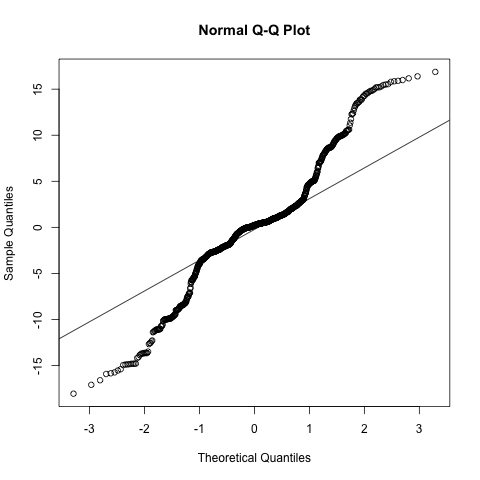

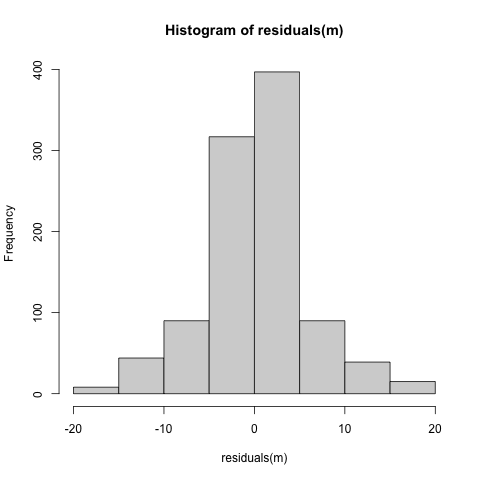

In [189]:
%%R -i all_df

# Sanitize dataframe column names
library(janitor)
all_df <- clean_names(all_df)

all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$operating_system <- factor(all_df$operating_system)

# Tried bootstrapping, didn't help normality much
# all_df <- sample_n(all_df, 1000, replace = TRUE)

# all_df$log_mem <- log10(all_df$memory_usage_percent_of_memory)

# print(head(all_df))

# Use a QQ plot and histogram to check normality
# We use log_time because we already checked that runtime_ms is not normal
# Also cpu_usage_percent_of_cpu, memory_usage_percent_of_memory
m = aov(memory_usage_percent_of_memory ~ condition*benchmark*operating_system, data=all_df)
qqnorm(residuals(m))
qqline(residuals(m))
hist(residuals(m))

In [195]:
%%R -i all_df

# Sanitize dataframe column names
library(janitor)
all_df <- clean_names(all_df)

all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)

# Get means and CIs
for (d in levels(all_df$device)) {
    for (c in levels(all_df$condition)) {
        dev_df <- filter(all_df, device == d & condition == c)
        
        num_samp <- 1000
        boot_samples <- matrix(sample(dev_df$memory_usage_percent_of_memory, size=nrow(dev_df)*num_samp, replace=TRUE), num_samp, nrow(dev_df))
        boot_stats <- apply(boot_samples, 1, mean)
        error <- 2 * sd(boot_stats)
        print(paste(d, c, "Mean:", mean(dev_df$memory_usage_percent_of_memory), "±", error))
    }
}

# sample(all_df$memory_usage_percent_of_memory, size = 500000, replace = TRUE)

[1] "Mac 1 Docker Mean: 11.9969685131651 ± 0.0135836674840118"
[1] "Mac 1 Native Mean: 58.6961640625 ± 0.0105809749022214"
[1] "Mac 2 Docker Mean: 35.3630850980699 ± 0.0349565011786998"
[1] "Mac 2 Native Mean: 38.819609375 ± 0.00362367772546492"
[1] "Ubuntu 1 Docker Mean: 27.43003125 ± 0.0132997597165675"
[1] "Ubuntu 1 Native Mean: 26.63103125 ± 0.0106673873921355"
[1] "Ubuntu 2 Docker Mean: 25.77940625 ± 0.00847679649589026"
[1] "Ubuntu 2 Native Mean: 24.9113125 ± 0.00555241970657811"
[1] "Ubuntu 3 Docker Mean: 22.4009375 ± 0.0100437916251868"
[1] "Ubuntu 3 Native Mean: 22.0188359375 ± 0.0101167225230699"
[1] "Windows 1 Docker Mean: 29.5448359375 ± 0.0209950293881203"
[1] "Windows 1 Native Mean: 57.0996953125 ± 0.0437738035669908"
[1] "Windows 2 Docker Mean: 29.5822720525041 ± 0.0192462853419576"
[1] "Windows 2 Native Mean: 54.0704921875 ± 0.0615524731969382"


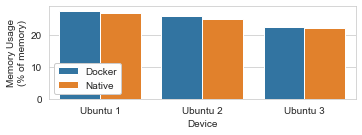

In [202]:
fig, ax = plt.subplots(figsize=(5.5, 1.7))

dev = ['Ubuntu 1', 'Ubuntu 2', 'Ubuntu 3']

sns.barplot(x='Device', y='Memory Usage (% of memory)', hue='Condition', ci=95, data=all_df, ax=ax, order=dev)
ax.set_xticklabels(labels=dev)
ax.set_ylabel('Memory Usage\n(% of memory)')
ax.legend(loc='lower left', framealpha=2)
plt.savefig('MemoryUsageSingleCol.pdf')

## CPU Analysis

In [ ]:
%%R -i all_df

library(janitor) # Fix dataframe column names to sanitize
all_df <- clean_names(all_df)

library(multcomp)
all_df$condition <- factor(all_df$condition)
all_df$benchmark <- factor(all_df$benchmark)
all_df$device <- factor(all_df$device)
all_df$operating_system <- factor(all_df$operating_system)

significance <- data.frame(benchmark = character(),
             os = character(),
             p = double())

print(levels(all_df$benchmark))

print("**************************** For each benchmark, look for differences ****************************")
for (b in c("Rotate", "SIFT", "SURF")) {
    bench_df <- filter(all_df, benchmark == b)

    print("------------------------------------------------------------")
    print(b)
    print("------------------------------------------------------------")
    print("--------------------------Overall---------------------------")
    
    result <- ezANOVA(data=bench_df, type=1, dv=log_time, wid=device, within=condition, between=operating_system, return_aov=TRUE, detailed=TRUE)
    print(result)
#     print("TRYING THIS:")
#     print(summary(glht(result$aov, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    print("The following compares OSs for this benchmark WITHOUT considering the condition in the Tukey")
    m = aov(log_time ~ condition * operating_system, data=bench_df)
    print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    
    # For each OS, we do individual t-tests for each benchmark and OS
    print(paste("--------------------------Test condition diffs by OS---------------------------"))
    print("The following compares conditions for a single OS")
    for (os in levels(bench_df$operating_system)) {
        print(paste("--------------------------OS: ", os, "---------------------------"))
        os_bench_df <- filter(bench_df, operating_system == os)
        
        d_os_bench_df <- filter(os_bench_df, condition == "Docker")
        print(paste("Docker: Mean: ", mean(d_os_bench_df$run_time_ms), ", StDev: ", sd(d_os_bench_df$run_time_ms)))
        n_os_bench_df <- filter(os_bench_df, condition == "Native")
        print(paste("Native: Mean: ", mean(n_os_bench_df$run_time_ms), ", StDev: ", sd(n_os_bench_df$run_time_ms)))
        print(paste("Difference: Absolute: ", mean(d_os_bench_df$run_time_ms) - mean(n_os_bench_df$run_time_ms),
                    ", Percent: ", (mean(d_os_bench_df$run_time_ms)/mean(n_os_bench_df$run_time_ms) - 1) * 100, "%"))
        
        t_result <- t.test(log_time ~ condition, var.equal=FALSE, paired=FALSE, data=os_bench_df)
        print(t_result)
#         m = aov(log_time ~ condition, data=os_bench_df)
#         m_summary = summary(m)
#         print(m_summary)
#         print(ezANOVA(data=os_bench_df, type=1, dv=log_time, wid=device, within=condition))
        # generalized eta squared
        
#         print(t_result$statistic)
#         print(t_result$p.value)
        
        significance[nrow(significance) + 1,] = list(b, os, t_result$p.value)
    }
    
    print(paste("--------------------------Test OS diffs by condition---------------------------"))
    print("This shows differences in OS for a specific benchmark and condition")
    for (c in levels(all_df$condition)) {
        cond_df <- filter(bench_df, condition == c)
        print(paste("--------------------------Condition: ", c, "---------------------------"))
        print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system, return_aov=TRUE, detailed=TRUE))
        m = aov(log_time ~ operating_system, data=cond_df)
        print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
    }
}

print("**************************** For each condition (overall, over all benchmarks), look for differences between OSs ****************************")
print("Note that none of the differences are significant")
for (c in levels(all_df$condition)) {
    cond_df <- filter(all_df, condition == c)
    
    print("------------------------------------------------------------")
    print(c)
    print("------------------------------------------------------------")
    print(ezANOVA(data=cond_df, type=1, dv=log_time, wid=device, between=operating_system))
#     m <- aov(log_time ~ operating_system, data=cond_df)
#     print(summary(glht(m, linfct = mcp(operating_system="Tukey")), test=adjusted(type="holm")))
}

# print(head(significance))


# Graphing Relative Run Time Performance (ALL)

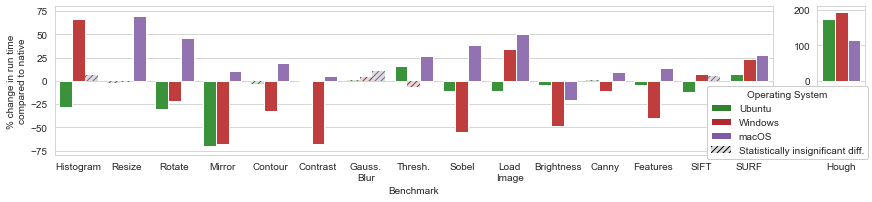

In [266]:
sns.set_style("whitegrid")

all_means = all_df.groupby(['Benchmark', 'Operating System', 'Condition']).mean()

# Gets % diff compared to native
perf_ratios = all_means.groupby(['Benchmark', 'Operating System']).apply(
    lambda d : (d.loc[ : , : , 'Docker'] / d.loc[ : , : , 'Native'] - 1) * 100
)
# Fix the naming of the performance ratio for run time
perf_ratios.rename(inplace=True, columns={
    'Run Time (ms)': '% change in run time compared to native'
})
# Fix a random problem with the index
perf_ratios = perf_ratios.reset_index(level=[1,2], drop=True).reset_index()

# Turn the benchmark into a category so we can sort it
perf_ratios['Benchmark'] = perf_ratios['Benchmark'].astype('category')

# Ready for plotting
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(12)
fig.set_figheight(2.7)
widths=[15, 1]
yMax = [80, 210]
yMin = [-80, -210]
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
benchSets = [
  ['Compute Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast Randomization',
   'Gaussian Blur', 'Mean Thresholding', 'Gradient Sobel',
   'Load Image', 'Brightness Randomization', 'Compute Canny', 'Good Features',
   'SIFT', 'SURF'],
  ['Hough Lines']
]
abbrs = [
    ['Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast',
    'Gauss.\nBlur',  'Thresh.', 'Sobel',
    'Load\nImage', 'Brightness', 'Canny', 'Features',
    'SIFT', 'SURF'],
    ['Hough']
]
oss = ['Ubuntu', 'Windows', 'macOS']
colors = ['#30822d', '#b02930', '#7f5ba3']

# Make the axes
axes = []
for col in range(2):
  axes += [fig.add_subplot(gs[0, col])]

# For each subset of benchmarks, draw it and have fun!
for col, benches in enumerate(benchSets):
  ratios_subset = perf_ratios[perf_ratios['Benchmark'].isin(benches)]
  
  # Sort the benchmarks because they're probably out of order now
  ratios_subset['Benchmark'].cat.set_categories(benches, inplace=True)
  ratios_subset.sort_values(['Benchmark'])

  b = sns.barplot(
      x='Benchmark', y='% change in run time compared to native',
      hue='Operating System', hue_order=oss,
      palette=["C2", "C3", "C4"],
      data=ratios_subset, ax=axes[col],
  )
  axes[col].set(ylabel='% change in run time\ncompared to native')
    
  for i, bar in enumerate(b.patches):
    # Get the benchmark and os for this bar using math
    curr_bench = benchSets[col][i % len(benches)]
    os = oss[i // len(benches)]
    
    # If the difference is insignificant, make the bar gray
    if significance[(significance['benchmark'] == curr_bench) & (significance['os'] == os)].iloc[0]['p'] > 0.05:
      bar.set(color='#DDD', linewidth=0, edgecolor=colors[i // len(benches)], hatch='////')

#   axes[col].set_xticklabels([b.replace(" ", "\n") for b in benches], rotation=90, ma='right')
  axes[col].set_xticklabels(abbrs[col])

  # Set the y limit
  axes[col].set_ylim(ymax=yMax[col], ymin=yMin[col])

  # Only first subfig has axes
  if col != 0:
    axes[col].set_ylabel(None)
    axes[col].set_xlabel(None)
    
  # Remove the legends
  axes[col].get_legend().set_visible(False)

legend_elements = []
legend_labels = oss + ['Statistically insignificant diff.']
for i, os in enumerate(oss):
  legend_elements += [patches.Patch(facecolor=colors[i])]
legend_elements += [patches.Patch(facecolor='#DDD', hatch='////', edgecolor='#000', linewidth=0)]

# fig.legend(legend_elements, legend_labels, framealpha=1, loc=(0.84, 0.36), title='Operating System')
fig.legend(legend_elements, legend_labels, framealpha=1, loc=(0.81, 0.21), title='Operating System')

plt.savefig('PercentRuntimeChangeDoubleCol.pdf')

# Graphing Absolute Run Time Performance (ALL)

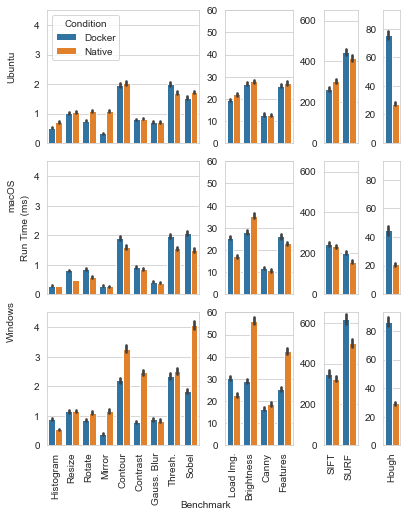

In [100]:
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(5.5)
fig.set_figheight(7)
widths=[0.2, 9, 4, 2, 1]
gs = fig.add_gridspec(ncols=5, nrows=3, width_ratios=widths)

benchSets = [
  ['Compute Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast Randomization',
   'Gaussian Blur', 'Mean Thresholding', 'Gradient Sobel'],
  ['Load Image', 'Brightness Randomization', 'Compute Canny', 'Good Features'],
  ['SIFT', 'SURF'],
  ['Hough Lines']
]
abbrs = [
    ['Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast',
    'Gauss. Blur',  'Thresh.', 'Sobel'],
    ['Load Img.', 'Brightness', 'Canny', 'Features'],
    ['SIFT', 'SURF'],
    ['Hough']
]
limits = [4.5, 60, 650, 93]

axes = []
for row in range(3):
  axes += [[]]
  startAt = 1
  for col, benches in enumerate(benchSets):
    endAt = startAt + 1 # len(benches)
    axes[row] += [fig.add_subplot(gs[row, startAt:endAt])]
    startAt = endAt

for row, os in enumerate(['Ubuntu', 'macOS', 'Windows']):
  
  for col, benches in enumerate(benchSets):
    # Get the docker condition into a dataframe
    all_3_v1 = all_df[
      #(all_df['Kernel Width (# pixels)'] == 3)
      #& (all_df['Source Video'] == 'Video1')
      (all_df['Benchmark'].isin(benches))
      & (all_df['Operating System'] == os)
    ]

    sns.barplot(x="Benchmark", y="Run Time (ms)",
                  order=benches,
                  hue="Condition", ax=axes[row][col],
                  data=all_3_v1)
    
    # Hide the legend, except for the first fig
    if row != 0 or col != 0:
      axes[row][col].get_legend().set_visible(False)
    else:
      axes[row][col].legend(loc='upper left', title='Condition')

    # Modify x_ticklabels based on the row
    if row < 2:
      axes[row][col].set_xticklabels([])
    else:  
#       axes[row][col].set_xticklabels([b.replace(" ", "\n") for b in benches], rotation=90, ma='right')
      axes[row][col].set_xticklabels(abbrs[col], rotation=90)

    # Remove y axis
    if row != 1 or col != 0:
      axes[row][col].set_ylabel(None)

    # Remove x axis
    axes[row][col].set_xlabel(None)

    # Set the y limit
    axes[row][col].set_ylim(ymax=limits[col])

fig.text(0.5, 0, 'Benchmark', ha='center')
fig.text(0, 0.875, 'Ubuntu', va='center', rotation='vertical')
fig.text(0, 0.62, 'macOS', va='center', rotation='vertical')
fig.text(0, 0.37, 'Windows', va='center', rotation='vertical')

plt.savefig('AbsRuntimeSingleCol.pdf')

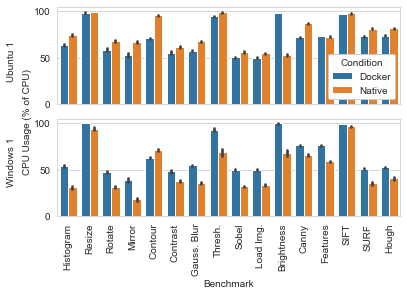

In [283]:
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(5.5)
fig.set_figheight(4)
widths=[0.2, 5]
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths)

bench_order = [
    'Compute Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast Randomization',
    'Gaussian Blur', 'Mean Thresholding', 'Gradient Sobel',
    'Load Image', 'Brightness Randomization', 'Compute Canny', 'Good Features',
    'SIFT', 'SURF',
    'Hough Lines'
]
abbrs = [
    'Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast',
    'Gauss. Blur',  'Thresh.', 'Sobel',
    'Load Img.', 'Brightness', 'Canny', 'Features',
    'SIFT', 'SURF',
    'Hough'
]

devices = ['Ubuntu 1', 'Windows 1']

axes = [fig.add_subplot(gs[row, 1:2]) for row in range(len(devices))]

for row, device in enumerate(devices):
  # Get the docker condition into a dataframe
  all_3_v1 = all_df[
    (all_df['Device'] == device)
  ]

  sns.barplot(x="Benchmark", y="CPU Usage (% of CPU)",
                hue="Condition", ax=axes[row],
                data=all_3_v1)
    
  # Hide the legend, except for the first fig
  if row != 0:
    axes[row].get_legend().set_visible(False)
  else:
    axes[row].legend(loc='lower right', framealpha=1, title='Condition')

  # Modify x_ticklabels based on the row
  if row < 1:
    axes[row].set_xticklabels([])
  else:  
    axes[row].set_xticklabels(abbrs, rotation=90)

  # Remove y axis
#   if row != 1:
  axes[row].set_ylabel(None)

  # Remove x axis
  if row != 1:
    axes[row].set_xlabel(None)

  # Set the y limit
  axes[row].set_ylim(ymax=105)

fig.text(0, 0.80, 'Ubuntu 1', va='center', rotation='vertical')
fig.text(0.04, 0.59, 'CPU Usage (% of CPU)', va='center', rotation='vertical')
fig.text(0, 0.45, 'Windows 1', va='center', rotation='vertical')

plt.savefig('CPUMachine3SingleCol.pdf')

Ubuntu 1
Ubuntu 2
Ubuntu 3
Windows 1
Windows 2
Mac 1
Mac 2


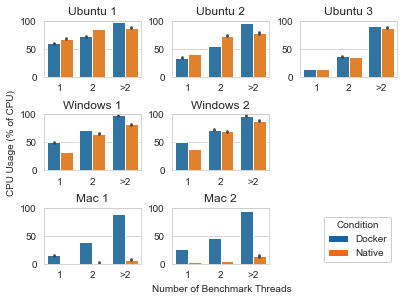

In [269]:
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(5.5)
fig.set_figheight(4)
# widths=[0.2, 5]
gs = fig.add_gridspec(ncols=6, nrows=4, height_ratios=[1,1,1,0.03]) #, width_ratios=widths)

bench_sets = [
    ['Load Image', 'Rotate', 'Mirror', 'Contrast Randomization', 'Brightness Randomization', 'Mean Thresholding', 'Gradient Sobel', 'Good Features', 'Hough Lines'],
    ['Contour', 'Compute Canny', 'SIFT'],
    ['Resize', 'Gaussian Blur', 'Compute Histogram', 'SURF'],
]

bench_sets = {
    'Load Image': '1',
    'Rotate' : '1',
    'Mirror': '1',
    'Contrast Randomization': '1',
    'Brightness Randomization': '1',
    'Mean Thresholding': '1',
    'Gradient Sobel': '1',
    'Good Features': '1',
    'Hough Lines': '1',
    'Contour': '2',
    'Compute Canny': '2',
    'SIFT': '2',
    'Resize': '>2',
    'Gaussian Blur': '>2',
    'Compute Histogram': '>2',
    'SURF': '>2',
}

bench_set_names = ['1', '2', '>2']

all_grouped = pd.DataFrame(all_df)

all_grouped['Number of Benchmark Threads'] = all_grouped.apply(lambda x : bench_sets[x['Benchmark']], axis=1)


devices = [
    [f'Ubuntu {i}' for i in range(1, 4)],
    [f'Windows {i}' for i in range(1, 3)],
    [f'Mac {i}' for i in range(1, 3)],
]

col_size = [
    [2,2,2],
    [2,2],
    [2,2],
]

axes = [
    [fig.add_subplot(gs[row, col*size:col*size+size]) for col, size in enumerate(col_size[row])]
    for row, device_row in enumerate(devices)
]

for row, device_row in enumerate(devices):
  for col, device in enumerate(device_row):
    print(device)
    # Get the docker condition into a dataframe
    all_3_v1 = all_df[
      (all_df['Device'] == device)
    ]

    sns.barplot(x='Number of Benchmark Threads', y="CPU Usage (% of CPU)",
                hue="Condition", ax=axes[row][col],
                order=bench_set_names,
                data=all_3_v1)

    # Hide the legend, except for the first fig
#     if row != 0 or col != 0:
    axes[row][col].get_legend().set_visible(False)
#     else:
#       axes[row][col].legend(loc='lower right', framealpha=0.8, title='Condition')

    # Modify x_ticklabels based on the row
#     if row < 1:
#       axes[row][col].set_xticklabels([])
    #   else:
    #     axes[row].set_xticklabels(bench_set_names, rotation=90)

    # Remove y axis
    if row != 1 or col != 0:
      axes[row][col].set_ylabel(None)
    axes[row][col].set_title(device)

    # Remove x axis
#     if row != 2 :
    axes[row][col].set_xlabel(None)

    # Set the y limit
    axes[row][col].set_ylim(ymax=100)

# l = axes[0][0].get_legend()
legend_els = [patches.Patch(facecolor=c) for c in ['#3273a1', '#e1802c']]

fig.legend(legend_els, ['Docker', 'Native'], loc=(0.8, 0.13), framealpha=1, title='Condition')
# fig.text(0, 0.80, 'Ubuntu 1', va='center', rotation='vertical')
fig.text(0.55, 0, 'Number of Benchmark Threads', ha='center')
# fig.text(0, 0.45, 'Windows 1', va='center', rotation='vertical')

plt.savefig('CPUAllMachinesSingleCol.pdf')

Ubuntu 1
Ubuntu 2
Ubuntu 3


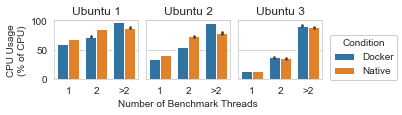

In [282]:
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(5.5)
fig.set_figheight(1.6)
gs = fig.add_gridspec(ncols=4, nrows=2, height_ratios=[1,0.01], width_ratios=[1,1,1,0.8])

bench_sets = [
    ['Load Image', 'Rotate', 'Mirror', 'Contrast Randomization', 'Brightness Randomization', 'Mean Thresholding', 'Gradient Sobel', 'Good Features', 'Hough Lines'],
    ['Contour', 'Compute Canny', 'SIFT'],
    ['Resize', 'Gaussian Blur', 'Compute Histogram', 'SURF'],
]

bench_sets = {
    'Load Image': '1',
    'Rotate' : '1',
    'Mirror': '1',
    'Contrast Randomization': '1',
    'Brightness Randomization': '1',
    'Mean Thresholding': '1',
    'Gradient Sobel': '1',
    'Good Features': '1',
    'Hough Lines': '1',
    'Contour': '2',
    'Compute Canny': '2',
    'SIFT': '2',
    'Resize': '>2',
    'Gaussian Blur': '>2',
    'Compute Histogram': '>2',
    'SURF': '>2',
}

bench_set_names = ['1', '2', '>2']

all_grouped = pd.DataFrame(all_df)

all_grouped['Number of Benchmark Threads'] = all_grouped.apply(lambda x : bench_sets[x['Benchmark']], axis=1)


devices = [
    [f'Ubuntu {i}' for i in range(1, 4)]
]

col_size = [
    [1,1,1]
]

axes = [
    [fig.add_subplot(gs[row, col*size:col*size+size]) for col, size in enumerate(col_size[row])]
    for row, device_row in enumerate(devices)
]

for row, device_row in enumerate(devices):
  for col, device in enumerate(device_row):
    print(device)
    # Get the docker condition into a dataframe
    all_3_v1 = all_df[
      (all_df['Device'] == device)
    ]

    sns.barplot(x='Number of Benchmark Threads', y="CPU Usage (% of CPU)",
                hue="Condition", ax=axes[row][col],
                order=bench_set_names,
                data=all_3_v1)

    # Hide the legend, except for the first fig
#     if row != 0 or col != 0:
    axes[row][col].get_legend().set_visible(False)
#     else:
#       axes[row][col].legend(loc='lower right', framealpha=0.8, title='Condition')

    # Modify x_ticklabels based on the row
#     if row < 1:
#       axes[row][col].set_xticklabels([])
    #   else:
    #     axes[row].set_xticklabels(bench_set_names, rotation=90)

    # Remove y axis
    if row != 0 or col != 0:
      axes[row][col].set_ylabel(None)
      axes[row][col].set_yticklabels([])
    else:
      axes[row][col].set_ylabel('CPU Usage\n(% of CPU)')

    axes[row][col].set_title(device)

    # Remove x axis
    if col != 1 :
      axes[row][col].set_xlabel(None)

    # Set the y limit
    axes[row][col].set_ylim(ymax=100)

# l = axes[0][0].get_legend()
legend_els = [patches.Patch(facecolor=c) for c in ['#3273a1', '#e1802c']]

fig.legend(legend_els, ['Docker', 'Native'], loc='center right', framealpha=1, title='Condition')
# fig.text(0, 0.80, 'Ubuntu 1', va='center', rotation='vertical')
# fig.text(0.55, 0, 'Number of Benchmark Threads', ha='center')
# fig.text(0, 0.45, 'Windows 1', va='center', rotation='vertical')

plt.savefig('CPUUbuntuSingleCol.pdf')

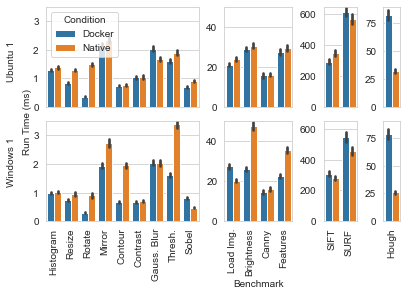

In [149]:
fig = plt.figure(constrained_layout=True)
fig.set_figwidth(5.5)
fig.set_figheight(4)
widths=[0.9, 9, 4, 2, 1]
gs = fig.add_gridspec(ncols=5, nrows=2, width_ratios=widths)

benchSets = [
  ['Compute Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast Randomization',
   'Gaussian Blur', 'Mean Thresholding', 'Gradient Sobel'],
  ['Load Image', 'Brightness Randomization', 'Compute Canny', 'Good Features'],
  ['SIFT', 'SURF'],
  ['Hough Lines']
]
abbrs = [
    ['Histogram', 'Resize', 'Rotate', 'Mirror', 'Contour', 'Contrast',
    'Gauss. Blur',  'Thresh.', 'Sobel'],
    ['Load Img.', 'Brightness', 'Canny', 'Features'],
    ['SIFT', 'SURF'],
    ['Hough']
]
limits = [3.5, 50, 650, 90]


devices = ['Ubuntu 1', 'Windows 1']

axes = [[fig.add_subplot(gs[row, i:i+1]) for i in range(1, 5)] for row in range(len(devices))]

for row, device in enumerate(devices):
  for col, benches in enumerate(benchSets):
    # Get the docker condition into a dataframe
    all_3_v1 = all_df[
      (all_df['Device'] == device)
      & (all_df['Benchmark'].isin(benches))
    ]

    sns.barplot(x="Benchmark", y="Run Time (ms)",
                hue="Condition", ax=axes[row][col],
                data=all_3_v1)

    # Hide the legend, except for the first fig
    if row != 0 or col != 0:
      axes[row][col].get_legend().set_visible(False)
    else:
      axes[row][col].legend(loc='upper left', title='Condition')

    # Modify x_ticklabels based on the row
    if row < 1:
      axes[row][col].set_xticklabels([])
    else:  
      axes[row][col].set_xticklabels(abbrs[col], rotation=90)

    # Remove y axis
    #   if row != 1:
    axes[row][col].set_ylabel(None)

    # Remove x axis
    if row != 1 or col != 1:
      axes[row][col].set_xlabel(None)

    # Set the y limit
    axes[row][col].set_ylim(ymax=limits[col])

fig.text(0, 0.80, 'Ubuntu 1', va='center', rotation='vertical')
fig.text(0.04, 0.59, 'Run Time (ms)', va='center', rotation='vertical')
fig.text(0, 0.45, 'Windows 1', va='center', rotation='vertical')

plt.savefig('AbsRuntimeMachineSingleCol.pdf')
